# Import Library 

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from Swarm import DFO

# Checking Data

In [3]:
# Path ke direktori data
happy_dir = 'data/happy'
sad_dir = 'data/sad'

In [ ]:
# Fungsi untuk load images
def load_images_from_folder(folder):
    images = []
    count = 0
    try:
        for filename in os.listdir(folder):
            count += 1
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    except:
        print(f'error pada iterasi ke-{count}')
    return images

In [5]:
happy_images = load_images_from_folder(happy_dir)
sad_images = load_images_from_folder(sad_dir)

In [6]:
happy_images[0].shape

(48, 48)

In [8]:
# Mengecek size setiap gambar happy apakah sama (48,48)
counter = 0
for image in happy_images:
  if str(image.shape) == '(48, 48)':
    counter += 1

if counter == len(happy_images):
  print('TRUE')
else:
  ('FALSE')

TRUE


In [9]:
# Mengecek size setiap gambar sad apakah sama (48,48)
counter = 0
for image in sad_images:
  if str(image.shape) == '(48, 48)':
    counter += 1

if counter == len(sad_images):
  print('TRUE')
else:
  ('FALSE')

TRUE


# Function for Preprocessing Data

In [10]:
def resize_images(images, img_size):
    """
    Fungsi untuk mengubah ukuran gambar.

    Args:
        images (list): List gambar yang akan diubah ukurannya.
        img_size (tuple): Ukuran gambar yang diinginkan (width, height).

    Returns:
        list: List gambar yang telah diubah ukurannya.
    """
    resized_images = []
    for img in images:
      resized_img = cv2.resize(img, img_size)
      resized_images.append(resized_img)
    return resized_images

In [11]:
# --- Fungsi Normalisasi Images ---
def normalize_images(images):
    """
    Melakukan normalisasi pada gambar grayscale.

    Args:
      images (list): List gambar yang akan dinormalisasi.

    Returns:
      list: List gambar yang telah dinormalisasi.
    """
    normalized_images = np.array(images) / 255.0
    return normalized_images

In [12]:
def augment_images(images):
    """
    Fungsi untuk melakukan augmentasi data pada gambar.

    Args:
        images (list): List gambar yang akan diaugmentasi.

    Returns:
        list: List gambar yang telah diaugmentasi.
    """
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    all_images = []  # List untuk menyimpan semua gambar (asli + augmentasi)
    for img in images:
        img = np.expand_dims(img, axis=-1)  # Tambahkan dimensi channel
        img = img.reshape((1,) + img.shape)  # Tambahkan dimensi batch

        all_images.append(img[0])  # Tambahkan gambar asli ke list

        # Generate gambar augmentasi dan tambahkan ke list
        for batch in datagen.flow(img, batch_size=1):
            all_images.append(batch[0])
            break  # Hanya ambil satu gambar augmentasi per gambar asli

    return all_images

In [13]:
# --- Fungsi Preprocessing ---
def preprocessing(happy_dir, sad_dir, img_size=(32, 32)):
    """
    Melakukan preprocessing pada data gambar.

    Args:
      happy_dir (str): Path ke direktori gambar "happy".
      sad_dir (str): Path ke direktori gambar "sad".
      img_size (tuple): Ukuran gambar yang diinginkan setelah resize (default: (32, 32)).
      augment (bool): Apakah akan melakukan augmentasi data (default: False).

    Returns:
      tuple: Tuple yang berisi data gambar dan label yang sudah di-preprocess.
    """
    happy_images = load_images_from_folder(happy_dir)
    sad_images = load_images_from_folder(sad_dir)

    happy_images = resize_images(happy_images, img_size)
    sad_images = resize_images(sad_images, img_size)

    happy_images = normalize_images(happy_images)
    sad_images = normalize_images(sad_images)

    happy_images = augment_images(happy_images)
    sad_images = augment_images(sad_images)

    # Gabungkan data dan buat label
    X = np.concatenate((happy_images, sad_images), axis=0) 
    y = np.concatenate((np.zeros(len(happy_images)), np.ones(len(sad_images))), axis=0)  # 0 = happy, 1 = sad
    y = y.astype(int)

    return X, y

In [14]:
X, y = preprocessing(happy_dir, sad_dir)

In [15]:
len(X)

5996

In [16]:
count_1 = 0
count_0 = 0
for i in y:
    if i == 0:
        count_0 += 1
    else:
        count_1 += 1

print(count_1)
print(count_0)
print(count_0 + count_1)

2924
3072
5996


In [17]:
# Bagi data menjadi training, validation set, dan testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [19]:
# Definisikan model LeNet-5
model = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 1)), # Sesuaikan dengan ukuran gambar
        layers.Conv2D(6, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(120, activation="relu"),
        layers.Dense(84, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [20]:
# Compile model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) 

In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 14, 14, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 5, 5, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,825 (714.16 KB)

 Trainable params: 60,941 (238.05 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 121,884 (476.11 KB)

In [21]:
# --- Fungsi Decode Fly Position ---
def decode_fly_position(fly):
  """
  Dekode posisi lalat (array 1D) menjadi bobot CNN (list of NumPy arrays).

  Args:
    fly (list): Posisi lalat dalam DFO.

  Returns:
    list: Bobot CNN.
  """

  weights = []
  start_index = 0

  for w in model.get_weights():
    # Hitung jumlah elemen dalam bobot
    w_size = np.prod(w.shape)

    # Ambil elemen dari posisi lalat sesuai dengan ukuran bobot
    w_values = fly[start_index : start_index + w_size]

    # Ubah bentuk elemen menjadi shape yang sesuai dengan bobot
    w_decoded = np.array(w_values).reshape(w.shape)

    # Tambahkan bobot yang telah didekode ke list
    weights.append(w_decoded)

    # Update start_index untuk bobot selanjutnya
    start_index += w_size

  return weights

In [32]:
# --- Fungsi Objektif untuk DFO ---
def objective_function(fly):
  """
  Fungsi objektif untuk DFO.

  Args:
    fly (list): Posisi lalat (representasi bobot CNN).

  Returns:
    float: Nilai fitness (akurasi atau loss).
  """

  # 1. Dekode posisi lalat menjadi bobot CNN
  weights = decode_fly_position(fly) 

  # 2. Tetapkan bobot ke model CNN
  model.set_weights(weights) 

  # 3. Latih model (sebagian epoch saja)
  history = model.fit(X_train, y_train, epochs=3, batch_size=32, 
                      validation_data=(X_val, y_val), verbose=0)

  # 4. Hitung nilai fitness
  #   Gunakan akurasi validasi
  fitness = history.history['val_loss'][-1]  

  return fitness

In [41]:
import random

class DFO():
    def __init__(self, f, bounds, NP, max_evals, dt):
        self.f = f
        self.bounds = bounds
        self.NP = NP
        self.max_evals = max_evals
        self.dt = dt
        """
        Args:
            f: Fungsi objektif yang akan diminimalkan.
            bounds: Batas atas dan bawah untuk setiap dimensi.
            NP: Jumlah lalat dalam populasi.
            max_evals: Jumlah maksimum evaluasi fungsi.
            dt: Parameter ambang batas.
        """
    def calculate_dfo(self):
        # Inisialisasi populasi lalat secara acak
        flies = [[random.uniform(self.bounds[d][0], self.bounds[d][1]) for d in range(len(self.bounds))] for _ in range(self.NP)]
        fitness = [self.f(fly) for fly in flies]  # Hitung fitness awal
        evals = self.NP  # Karena sayasudah menghitung fitness untuk NP lalat

        while evals < self.max_evals:
            print(f"Evaluasi: {evals},  Fitness Terbaik: {min(fitness)}")
            # Menemukan lalat terbaik (sb)
            sb_index = fitness.index(min(fitness))  # Indeks lalat terbaik
            sb = flies[sb_index]  # Lalat terbaik

            # Menemukan tetangga terbaik (nb) untuk setiap lalat
            nb = []
            for i in range(self.NP):
                left = flies[i-1] if i > 0 else flies[-1]  # Tetangga kiri
                right = flies[i+1] if i < self.NP-1 else flies[0]  # Tetangga kanan
                nb.append(min([left, right], key=lambda fly: fitness[flies.index(fly)]))  # Menggunakan fitness untuk menentukan tetangga terbaik

            # Memperbaharui posisi lalat
            for i in range(self.NP):
                for d in range(len(self.bounds)):
                    tau = nb[i][d] + random.uniform(0, 1) * (sb[d] - flies[i][d])
                    if random.random() < self.dt:
                        tau = self.bounds[d][0] + random.random() * (self.bounds[d][1] - self.bounds[d][0])
                    flies[i][d] = tau

                # Menghitung fitness untuk lalat yang diperbaharui
                fitness[i] = self.f(flies[i])  # Update fitness untuk lalat yang diperbaharui
                evals += 1

        # Mengembalikan lalat terbaik setelah semua evaluasi selesai
        best_index = fitness.index(min(fitness))
        return flies[best_index], fitness[best_index]  # Kembalikan posisi dan fitness terbaik

In [43]:
# Batas bobot (sesuaikan dengan rentang yang diinginkan)
# bounds = [(-1, 1)] * len(model.get_weights()) 
bounds = [(-1, 1)] * sum([np.prod(w.shape) for w in model.get_weights()]) 

# Parameter DFO
NP = 50  # Jumlah lalat
max_evals = 500  # Jumlah evaluasi maksimum
dt = 0.2   # Parameter ambang batas

In [44]:
total_elements = sum([np.prod(w.shape) for w in model.get_weights()])
print(total_elements) 

60941


In [45]:
len(bounds)

60941

# Find Best Weights from DFO using Val_loss as fitness

In [46]:
# Buat objek DFO
dfo_optimizer = DFO(objective_function, bounds, NP, max_evals, dt)

In [37]:
# Jalankan DFO
best_fly, best_fitness = dfo_optimizer.calculate_dfo()

In [47]:
best_fly

[0.07698119686843082,
 0.5606545770826128,
 -0.3517020106915125,
 0.23743875164503425,
 -1.631752771639036,
 -0.13738663518838856,
 -0.03646606964018506,
 -0.5243225218811389,
 -0.2063448729992734,
 0.5960565210522446,
 -0.17076266231628434,
 0.4926077253375456,
 0.4002750640106789,
 0.7007490228255253,
 -1.0879560370672392,
 -0.0628571265900782,
 -0.25790190580508376,
 0.7310821707006032,
 -1.0541495425377736,
 0.08164288334754222,
 -0.4461509047088439,
 0.4652278052372032,
 -0.18859373653443576,
 0.1791129117639525,
 -0.6515529971498017,
 0.36410607408527595,
 0.6617392148407235,
 -9.794042334557163e-05,
 0.8761952347494125,
 0.15289298632272824,
 -0.8096965509817788,
 0.6488183237154348,
 -0.9385630315519522,
 -0.6143929324407535,
 0.7913507920829856,
 -0.8571210058171723,
 0.03745260165502229,
 -0.7166166330545338,
 0.3353005716893742,
 -0.5271325193626383,
 -0.46547250503022863,
 -0.313039342430961,
 -0.7943713384579041,
 -0.264725935053302,
 -0.3012906217539846,
 -0.6219481375170

In [48]:
best_fitness

5.262434482574463

In [49]:
# Dekode bobot terbaik
best_weights = decode_fly_position(best_fly)

In [234]:
best_weights

[array([[[[ 0.47864561,  1.25909296, -0.11497272, -1.44888899,
            0.24622816,  1.09999436]],
 
         [[ 1.12600464, -0.65851703, -1.72875454, -0.49566287,
           -1.54572982,  0.36890968]],
 
         [[ 0.50237167,  0.05126666, -0.26621949,  0.94013935,
           -0.55379934, -1.1422555 ]],
 
         [[ 0.78052412,  0.99241191, -0.36911075,  0.81359921,
            0.43950981,  0.96231697]],
 
         [[-0.80437814, -0.29564784, -3.47175806, -1.47184555,
           -0.29859628, -0.37556924]]],
 
 
        [[[ 1.63516257,  0.90400814,  1.09806411,  0.95007574,
           -0.06518654,  0.01037901]],
 
         [[ 0.04113108, -0.24952217, -0.89153622, -0.44465821,
            0.34915601,  0.19164906]],
 
         [[-0.37874654,  0.53998219,  6.16456813, -0.06556295,
            0.30071481, -0.34600787]],
 
         [[ 0.77330758,  0.08626601, -0.31113079,  0.2304658 ,
           -2.14627138, -0.12569771]],
 
         [[-0.94164924, -0.01769057,  0.03552564,  0.77424725

In [116]:
# Tetapkan bobot terbaik ke model
model.set_weights(best_weights)

In [117]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train CNN LeNet-5 Model using Best Weights

In [118]:
# 5. Latih model dengan seluruh data training
history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
                    validation_data=(X_val, y_val), 
                    validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5117 - loss: 49.3901 - val_accuracy: 0.5050 - val_loss: 5.5455
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5236 - loss: 4.2317 - val_accuracy: 0.5206 - val_loss: 3.1439
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5171 - loss: 2.9530 - val_accuracy: 0.5150 - val_loss: 2.3879
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5322 - loss: 2.1858 - val_accuracy: 0.5473 - val_loss: 1.7876
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5153 - loss: 1.8515 - val_accuracy: 0.5217 - val_loss: 1.8897
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5221 - loss: 1.6407 - val_accuracy: 0.5139 - val_loss: 1.4211
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5073 - loss: 1.4685 - val_accuracy: 0.5072 - val_loss: 2.3765
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5106 - loss: 1.6117 - val_accuracy: 0.5061 -

In [119]:
# 6. Evaluasi model dengan data testing
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy) 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4788 - loss: 1.1095
Test Loss: 1.094568133354187
Test Accuracy: 0.4855555593967438


In [120]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Ubah probabilitas menjadi kelas (0 atau 1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
confusion_mat = confusion_matrix(y_test, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", confusion_mat)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.4855555555555556
Precision: 0.4855769230769231
Recall: 0.9202733485193622
F1-Score: 0.6357199055861527
Confusion Matrix:
 [[ 33 428]
 [ 35 404]]


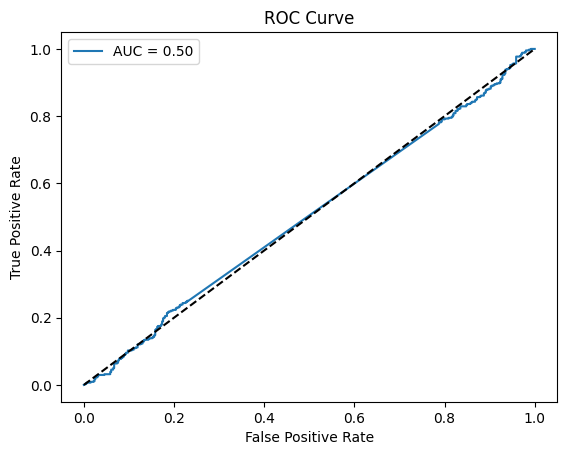

In [121]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

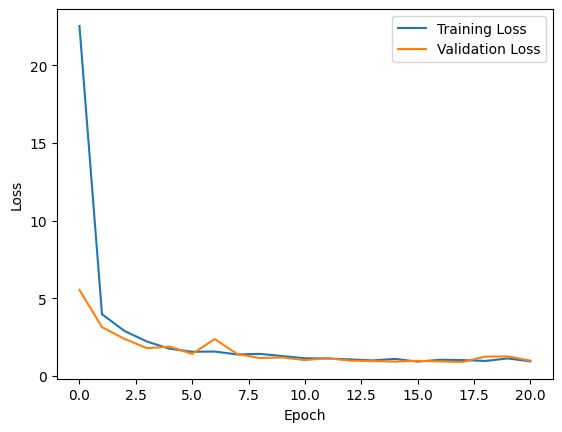

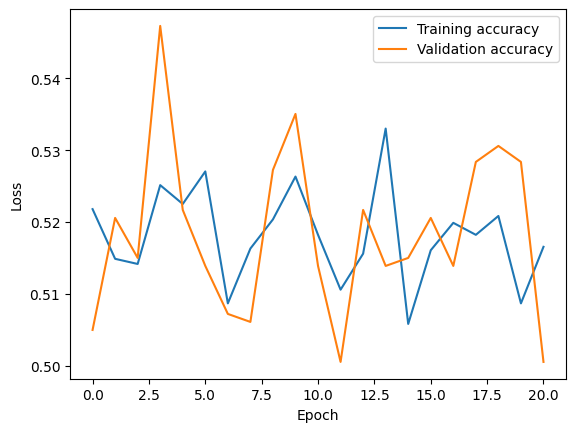

In [122]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
